<a href="https://colab.research.google.com/github/jwells52/creating-ai-enabled-systems/blob/main/Research%20Project/notebooks/FSL_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install EasyFSL

In [1]:
%pip install easyfsl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.2/65.2 kB 2.0 MB/s eta 0:00:00


### Download Humpback Whale Identification dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!rm -rf /root/.kaggle && mkdir /root/.kaggle && cp /content/drive/MyDrive/Research-Project/kaggle.json /root/.kaggle/kaggle.json && chmod 600 /root/.kaggle/kaggle.json && kaggle competitions download -c humpback-whale-identification
!unzip humpback-whale-identification.zip

### Clone GitHub repo

In [1]:
# !git clone https://github.com/jwells52/creating-ai-enabled-systems.git
%cd creating-ai-enabled-systems/Research\ Project

/content/creating-ai-enabled-systems/Research Project


### Imports

In [2]:
import os

import torch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

from easyfsl.methods import PrototypicalNetworks, FewShotClassifier, SimpleShot
from easyfsl.utils import evaluate
from easyfsl.samplers import TaskSampler

from torch import Tensor, nn
from torch.optim import SGD, Optimizer, Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18, resnet34, resnet152

from typing import Callable

from modules.data_utils import HumpbackWhaleDataset, remove_new_whale_class, create_loaders
from modules.train import train_fsl, device, transform


### Load dataset

In [3]:
train_df = remove_new_whale_class(
  pd.read_csv('/content/creating-ai-enabled-systems/Research Project/data/images_and_ids.csv')
)


train_df = train_df[train_df['class_count'] > 8]

In [4]:
print(f"Min # of samples for a class in training set = {train_df['class_count'].min()}")
print(f"Max # of samples for a class in training set = {train_df['class_count'].max()}")
print(f"# of classes in training set = {len(train_df['Id'].unique())}")


Min # of samples for a class in training set = 9
Max # of samples for a class in training set = 73
# of classes in training set = 335


### Define few shot learning network

In [5]:
cnn = resnet34().to(device)
few_shot_classifier = PrototypicalNetworks(cnn).to(device)

### Set up training

In [6]:
train_set = HumpbackWhaleDataset(
    image_dir='/content/train',
    labels=train_df,
    transform=transform
)


In [7]:
# Number of Training Task for each epoch
# A training task is a random sample of N shots (images) for M classes
n_task_per_epoch = 100

# Number of Validation tasks for evaluation during training
n_validation_tasks = 20

n_way   = 5
n_shot  = 3
n_query = 5

In [8]:
train_sampler = TaskSampler(
    train_set, n_way=n_way, n_shot=n_shot, n_query=n_query, n_tasks=n_task_per_epoch
)

In [9]:
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn
)

In [10]:
n_epochs = 100
learning_rate = 1e-2

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = SGD(few_shot_classifier.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)


### Train network

In [11]:
train_losses, valid_accs = train_fsl(
    few_shot_classifier,
    train_loader,
    None,
    optimizer,
    loss_fn,
    n_epochs=n_epochs,
    use_tqdm=True,
    save_model=True,
    save_path='/content/creating-ai-enabled-systems/Research Project/models/prototypical_network_resnet34_prod'
)


Epoch 1


Training: 100%|██████████| 100/100 [00:16<00:00,  6.00it/s, loss=1.59]


Epoch 2



Training: 100%|██████████| 100/100 [00:13<00:00,  7.40it/s, loss=1.32]


Epoch 3



Training: 100%|██████████| 100/100 [00:14<00:00,  7.13it/s, loss=1.13]


Epoch 4



Training: 100%|██████████| 100/100 [00:13<00:00,  7.23it/s, loss=1.01]



Epoch 5


Training: 100%|██████████| 100/100 [00:13<00:00,  7.40it/s, loss=0.911]


Epoch 6



Training: 100%|██████████| 100/100 [00:13<00:00,  7.17it/s, loss=0.786]



Epoch 7


Training: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s, loss=0.744]


Epoch 8



Training: 100%|██████████| 100/100 [00:13<00:00,  7.40it/s, loss=0.664]


Epoch 9



Training: 100%|██████████| 100/100 [00:14<00:00,  7.13it/s, loss=0.639]



Epoch 10


Training: 100%|██████████| 100/100 [00:13<00:00,  7.40it/s, loss=0.592]



Epoch 11


Training: 100%|██████████| 100/100 [00:13<00:00,  7.14it/s, loss=0.502]



Epoch 12


Training: 100%|██████████| 100/100 [00:13<00:00,  7.37it/s, loss=0.507]


Epoch 13



Training: 100%|██████████| 100/100 [00:14<00:00,  7.01it/s, loss=0.43]



Epoch 14


Training: 100%|██████████| 100/100 [00:14<00:00,  7.09it/s, loss=0.438]


Epoch 15



Training: 100%|██████████| 100/100 [00:13<00:00,  7.33it/s, loss=0.379]



Epoch 16


Training: 100%|██████████| 100/100 [00:13<00:00,  7.26it/s, loss=0.386]


Epoch 17



Training: 100%|██████████| 100/100 [00:13<00:00,  7.17it/s, loss=0.386]


Epoch 18



Training: 100%|██████████| 100/100 [00:13<00:00,  7.28it/s, loss=0.371]


Epoch 19



Training: 100%|██████████| 100/100 [00:13<00:00,  7.28it/s, loss=0.353]


Epoch 20



Training: 100%|██████████| 100/100 [00:13<00:00,  7.27it/s, loss=0.313]


Epoch 21



Training: 100%|██████████| 100/100 [00:13<00:00,  7.41it/s, loss=0.284]


Epoch 22



Training: 100%|██████████| 100/100 [00:14<00:00,  7.05it/s, loss=0.257]


Epoch 23



Training: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s, loss=0.273]


Epoch 24



Training: 100%|██████████| 100/100 [00:14<00:00,  7.10it/s, loss=0.27]


Epoch 25



Training: 100%|██████████| 100/100 [00:13<00:00,  7.34it/s, loss=0.261]



Epoch 26


Training: 100%|██████████| 100/100 [00:14<00:00,  7.11it/s, loss=0.242]


Epoch 27



Training: 100%|██████████| 100/100 [00:13<00:00,  7.17it/s, loss=0.247]


Epoch 28



Training: 100%|██████████| 100/100 [00:14<00:00,  7.08it/s, loss=0.229]


Epoch 29



Training: 100%|██████████| 100/100 [00:14<00:00,  7.02it/s, loss=0.194]



Epoch 30


Training: 100%|██████████| 100/100 [00:13<00:00,  7.27it/s, loss=0.197]



Epoch 31


Training: 100%|██████████| 100/100 [00:13<00:00,  7.37it/s, loss=0.186]



Epoch 32


Training: 100%|██████████| 100/100 [00:13<00:00,  7.22it/s, loss=0.152]


Epoch 33



Training: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s, loss=0.186]


Epoch 34



Training: 100%|██████████| 100/100 [00:13<00:00,  7.18it/s, loss=0.194]


Epoch 35



Training: 100%|██████████| 100/100 [00:13<00:00,  7.33it/s, loss=0.16]



Epoch 36


Training: 100%|██████████| 100/100 [00:14<00:00,  7.12it/s, loss=0.236]



Epoch 37


Training: 100%|██████████| 100/100 [00:13<00:00,  7.46it/s, loss=0.184]



Epoch 38


Training: 100%|██████████| 100/100 [00:13<00:00,  7.20it/s, loss=0.133]


Epoch 39



Training: 100%|██████████| 100/100 [00:13<00:00,  7.15it/s, loss=0.151]


Epoch 40



Training: 100%|██████████| 100/100 [00:13<00:00,  7.29it/s, loss=0.169]


Epoch 41



Training: 100%|██████████| 100/100 [00:13<00:00,  7.38it/s, loss=0.146]


Epoch 42



Training: 100%|██████████| 100/100 [00:13<00:00,  7.29it/s, loss=0.134]


Epoch 43



Training: 100%|██████████| 100/100 [00:13<00:00,  7.23it/s, loss=0.137]



Epoch 44


Training: 100%|██████████| 100/100 [00:13<00:00,  7.32it/s, loss=0.151]


Epoch 45



Training: 100%|██████████| 100/100 [00:13<00:00,  7.44it/s, loss=0.115]



Epoch 46


Training: 100%|██████████| 100/100 [00:14<00:00,  7.12it/s, loss=0.101]


Epoch 47



Training: 100%|██████████| 100/100 [00:13<00:00,  7.36it/s, loss=0.132]



Epoch 48


Training: 100%|██████████| 100/100 [00:13<00:00,  7.26it/s, loss=0.163]


Epoch 49



Training: 100%|██████████| 100/100 [00:13<00:00,  7.27it/s, loss=0.132]


Epoch 50



Training: 100%|██████████| 100/100 [00:13<00:00,  7.28it/s, loss=0.146]


Epoch 51



Training: 100%|██████████| 100/100 [00:13<00:00,  7.30it/s, loss=0.126]



Epoch 52


Training: 100%|██████████| 100/100 [00:14<00:00,  7.09it/s, loss=0.0963]


Epoch 53



Training: 100%|██████████| 100/100 [00:13<00:00,  7.36it/s, loss=0.0677]


Epoch 54



Training: 100%|██████████| 100/100 [00:14<00:00,  7.11it/s, loss=0.0912]


Epoch 55



Training: 100%|██████████| 100/100 [00:13<00:00,  7.35it/s, loss=0.0762]


Epoch 56



Training: 100%|██████████| 100/100 [00:13<00:00,  7.16it/s, loss=0.0998]


Epoch 57



Training: 100%|██████████| 100/100 [00:13<00:00,  7.34it/s, loss=0.117]


Epoch 58



Training: 100%|██████████| 100/100 [00:13<00:00,  7.25it/s, loss=0.0981]


Epoch 59



Training: 100%|██████████| 100/100 [00:13<00:00,  7.32it/s, loss=0.131]


Epoch 60



Training: 100%|██████████| 100/100 [00:13<00:00,  7.26it/s, loss=0.103]


Epoch 61



Training: 100%|██████████| 100/100 [00:13<00:00,  7.37it/s, loss=0.121]



Epoch 62


Training: 100%|██████████| 100/100 [00:13<00:00,  7.38it/s, loss=0.0749]



Epoch 63


Training: 100%|██████████| 100/100 [00:14<00:00,  7.13it/s, loss=0.0628]


Epoch 64



Training: 100%|██████████| 100/100 [00:13<00:00,  7.37it/s, loss=0.0648]


Epoch 65



Training: 100%|██████████| 100/100 [00:13<00:00,  7.36it/s, loss=0.0833]



Epoch 66


Training: 100%|██████████| 100/100 [00:13<00:00,  7.43it/s, loss=0.112]


Epoch 67



Training: 100%|██████████| 100/100 [00:13<00:00,  7.23it/s, loss=0.0788]



Epoch 68


Training: 100%|██████████| 100/100 [00:13<00:00,  7.53it/s, loss=0.0654]


Epoch 69



Training: 100%|██████████| 100/100 [00:13<00:00,  7.20it/s, loss=0.109]


Epoch 70



Training: 100%|██████████| 100/100 [00:14<00:00,  7.12it/s, loss=0.0933]



Epoch 71


Training: 100%|██████████| 100/100 [00:13<00:00,  7.21it/s, loss=0.0974]



Epoch 72


Training: 100%|██████████| 100/100 [00:13<00:00,  7.51it/s, loss=0.0741]


Epoch 73



Training: 100%|██████████| 100/100 [00:13<00:00,  7.20it/s, loss=0.0932]


Epoch 74



Training: 100%|██████████| 100/100 [00:14<00:00,  7.12it/s, loss=0.0832]



Epoch 75


Training: 100%|██████████| 100/100 [00:14<00:00,  7.04it/s, loss=0.0772]



Epoch 76


Training: 100%|██████████| 100/100 [00:13<00:00,  7.27it/s, loss=0.0654]


Epoch 77



Training: 100%|██████████| 100/100 [00:13<00:00,  7.33it/s, loss=0.0856]


Epoch 78



Training: 100%|██████████| 100/100 [00:13<00:00,  7.40it/s, loss=0.0863]


Epoch 79



Training: 100%|██████████| 100/100 [00:13<00:00,  7.36it/s, loss=0.074]



Epoch 80


Training: 100%|██████████| 100/100 [00:13<00:00,  7.44it/s, loss=0.069]


Epoch 81



Training: 100%|██████████| 100/100 [00:14<00:00,  7.09it/s, loss=0.0928]



Epoch 82


Training: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s, loss=0.0498]


Epoch 83



Training: 100%|██████████| 100/100 [00:13<00:00,  7.19it/s, loss=0.0774]


Epoch 84



Training: 100%|██████████| 100/100 [00:13<00:00,  7.29it/s, loss=0.111]


Epoch 85



Training: 100%|██████████| 100/100 [00:14<00:00,  7.10it/s, loss=0.0914]


Epoch 86



Training: 100%|██████████| 100/100 [00:13<00:00,  7.31it/s, loss=0.0706]


Epoch 87



Training: 100%|██████████| 100/100 [00:15<00:00,  6.64it/s, loss=0.0737]


Epoch 88



Training: 100%|██████████| 100/100 [00:13<00:00,  7.34it/s, loss=0.0633]


Epoch 89



Training: 100%|██████████| 100/100 [00:13<00:00,  7.27it/s, loss=0.0694]



Epoch 90


Training: 100%|██████████| 100/100 [00:13<00:00,  7.30it/s, loss=0.0658]


Epoch 91



Training: 100%|██████████| 100/100 [00:13<00:00,  7.41it/s, loss=0.0761]



Epoch 92


Training: 100%|██████████| 100/100 [00:13<00:00,  7.30it/s, loss=0.0632]



Epoch 93


Training: 100%|██████████| 100/100 [00:13<00:00,  7.32it/s, loss=0.0497]


Epoch 94



Training: 100%|██████████| 100/100 [00:13<00:00,  7.31it/s, loss=0.0611]


Epoch 95



Training: 100%|██████████| 100/100 [00:13<00:00,  7.21it/s, loss=0.0442]



Epoch 96


Training: 100%|██████████| 100/100 [00:13<00:00,  7.44it/s, loss=0.05]


Epoch 97



Training: 100%|██████████| 100/100 [00:13<00:00,  7.35it/s, loss=0.0455]


Epoch 98



Training: 100%|██████████| 100/100 [00:13<00:00,  7.36it/s, loss=0.0505]


Epoch 99



Training: 100%|██████████| 100/100 [00:13<00:00,  7.17it/s, loss=0.0565]



Epoch 100


Training: 100%|██████████| 100/100 [00:13<00:00,  7.14it/s, loss=0.0416]


Saving state of model checkpoint at last epoch to /content/creating-ai-enabled-systems/Research Project/models/prototypical_network_resnet34_prod_last_epoch


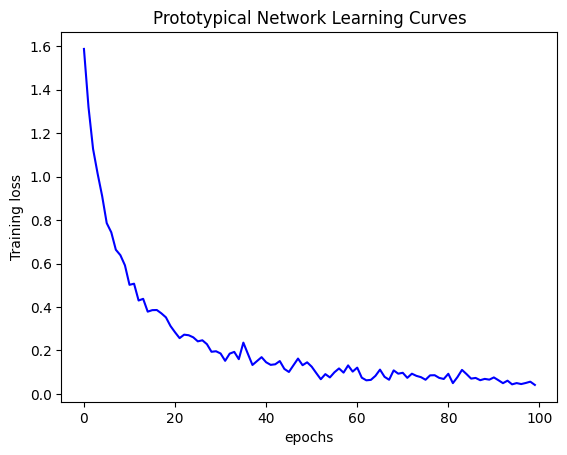

In [12]:
fig,ax = plt.subplots()

plt.title('Prototypical Network Learning Curves')

ax.plot(train_losses, color='blue')
ax.set_xlabel("epochs")
ax.set_ylabel('Training loss')

# ax2=ax.twinx()
# ax2.plot(valid_accs, color='orange')
# ax2.set_ylabel('Validation accuracy')

plt.show()
fig.savefig('/content/prototypical_network_resnet34_prod_learning_curves_100epochs.png', format='png')